# Normalizing flows

In [1]:
%cd ..

/data/mas322/amex-project


In [3]:
import yaml
import os
import importlib
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist 
import pyro.distributions.transforms as T

from src.experiments.static_preprocessing_methods.min_max_scaling import MinMaxTimeSeries
from src.experiments.static_preprocessing_methods.standard_scaling import StandardScalerTimeSeries
from src.lib import experimentation
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

LOAD_DATA = True

if LOAD_DATA:
    # load corrupted data
    torch.manual_seed(42)
    train_loader, val_loader = experimentation.load_numpy_data(
        os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
        val_idx=[2, 3],
        fill_dict=fill_dict,
        preprocess_obj=MinMaxTimeSeries(),
        corrupt_func=spm.undo_min_max_corrupt_func,
        dtype=torch.float32,
        **data_loader_kwargs)

    for X, y in train_loader:
        break
    X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
    print(f"X shape: {X.shape}")

X shape: (1024, 13, 177)


## Simple normalizing flow example

`T.ExpTransform()` implements $g(x)=\exp(x)$, for which $\log\left(\left| \frac{dg}{dx}\right|\right)=x$. We can pass in a list of transformations to the below method, and a base distribution e.g. `dist.Normal` object. The transformations are applied from left to right when going forwards

In [11]:
?dist.TransformedDistribution

Init signature:
dist.TransformedDistribution(
    base_distribution,
    transforms,
    validate_args=None,
)
Docstring:     
Wraps :class:`torch.distributions.transformed_distribution.TransformedDistribution` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/pyro/distributions/torch.py
Type:           DistributionMeta
Subclasses:     AffineBeta, FoldedDistribution, InverseGamma, LKJ

`T.AffineTransform` does a linear shift and scale

Learnable transformations should inherit from `dist.torch_transform.TransformModule`, not the `T` verison, which is only for fixed parameters. However, this is just child of both `T.Transform` and `nn.modules.module.Module`.

In [90]:
DEV = torch.device('cuda', 5)

half = (11, 91)
#half = (91, 188)
input_dim = half[1] - half[0]

base_dist = dist.Normal(torch.zeros(input_dim, device=DEV), torch.ones(input_dim, device=DEV))
bijector = get_iaf_bijector(2, [100], input_dim, DEV).to(DEV)
batch_preprocess_fn = lambda x : x.flatten(0, 1)[:, half[0]:half[1]]
fit_bijector(bijector, base_dist, train_loader, batch_preprocess_fn=batch_preprocess_fn)

1

In [5]:
torch.save(bijector.state_dict(), os.path.join(cfg['checkpoint_directory'], "bijector-model-12-07-2023-first-half"))

In [45]:
bijector.load_state_dict(torch.load(os.path.join(cfg['checkpoint_directory'], "bijector-model-12-07-2023-first-half")))

<All keys matched successfully>

Somehow just one lazy initialisation of the bijector uses up 18 GB of GPU memory, so trick is to save model state after training, then apply transformation using CPU perhaps?

In [7]:
out = bijector.inv(torch.tensor(X).flatten(0, 1).to(DEV))

In [10]:
out = out.detach().cpu().numpy()
X = X.reshape((-1, input_dim))

The below plots are misleading due to the random permutations...

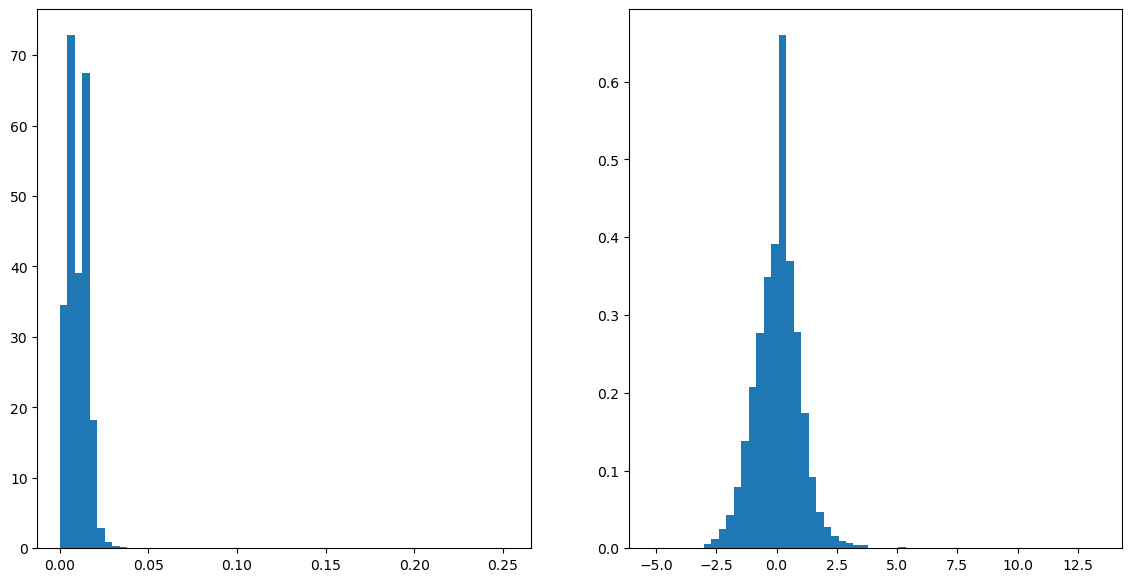

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:, 13], bins=60, density=True)
axs[1].hist(out[:, 13], bins=60, density=True)
plt.show()

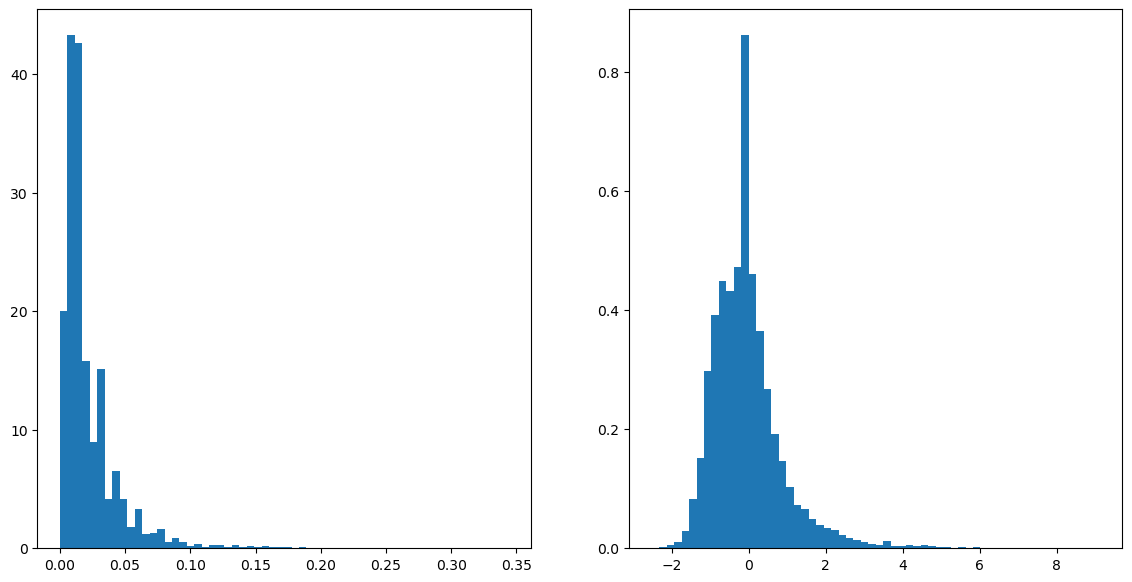

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   25], bins=60, density=True)
axs[1].hist(out[:, 25], bins=60, density=True)
plt.show()

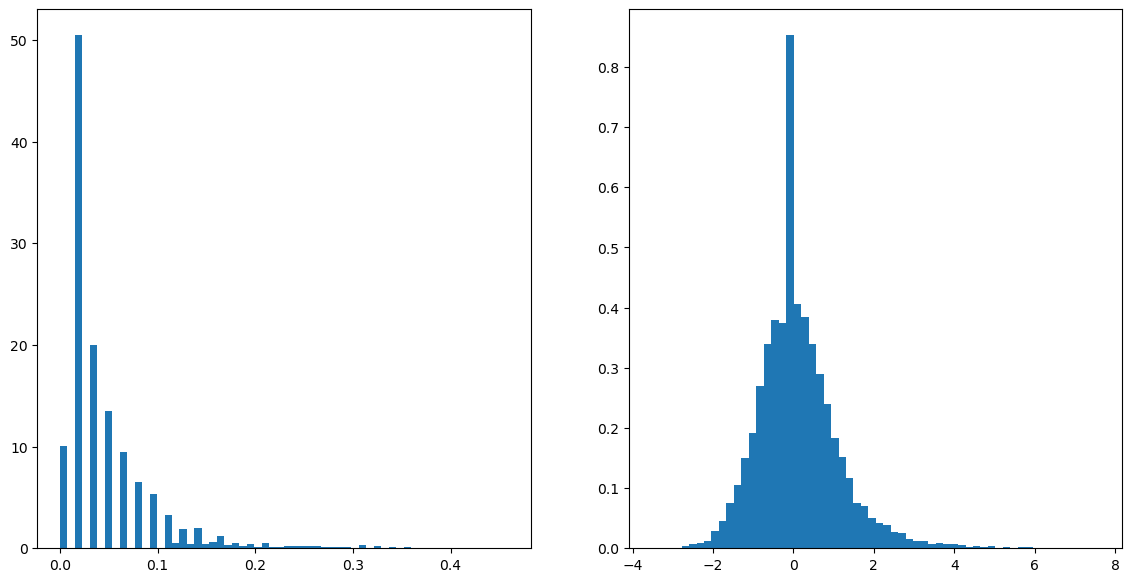

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   70], bins=60, density=True)
axs[1].hist(out[:, 70], bins=60, density=True)
plt.show()

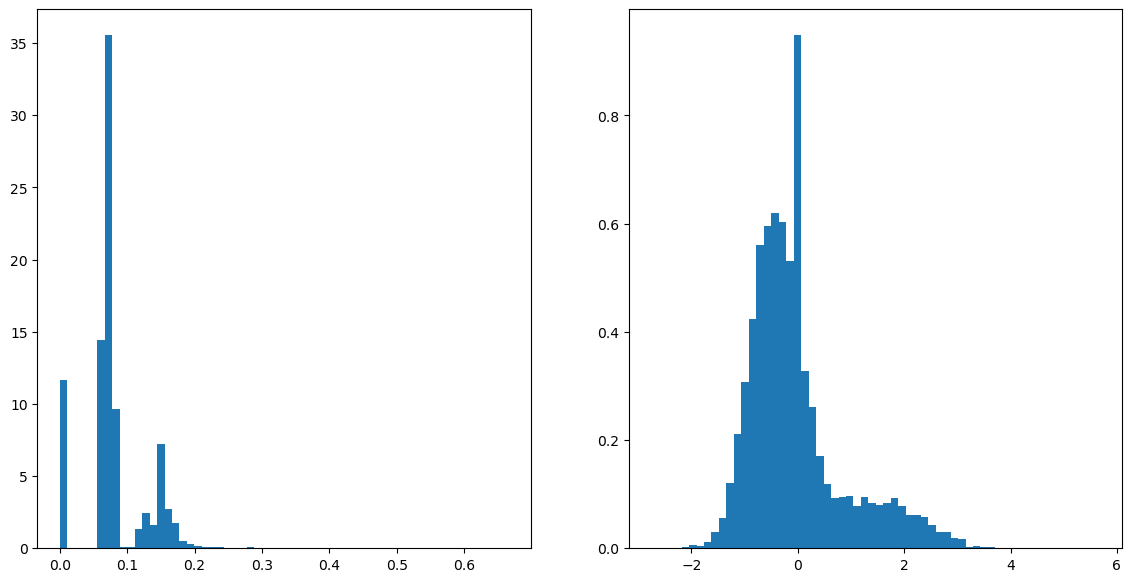

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   29], bins=60, density=True)
axs[1].hist(out[:, 29], bins=60, density=True)
plt.show()

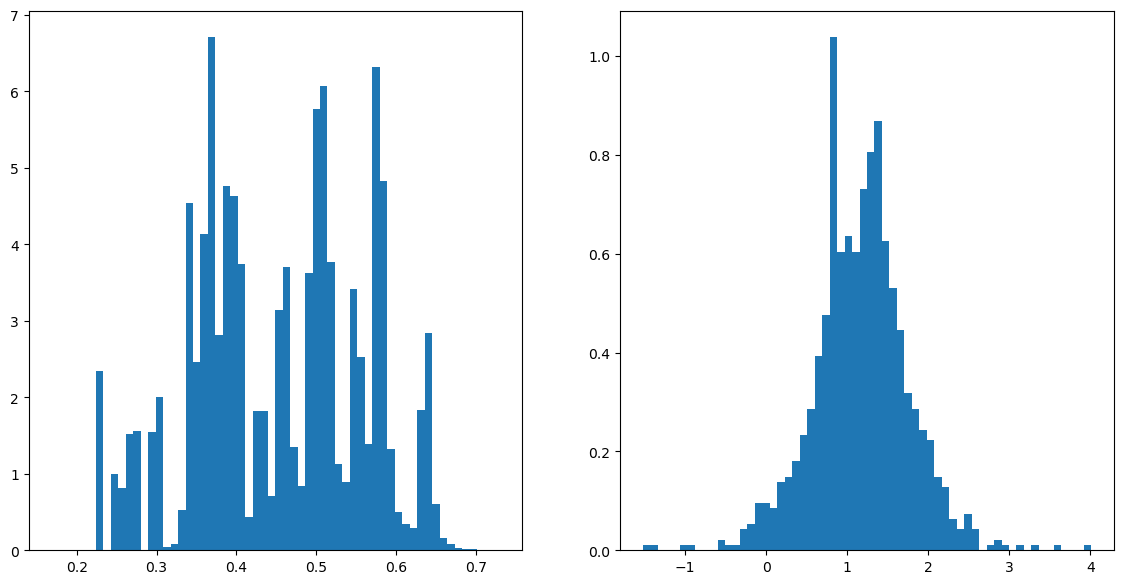

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[1].hist(torch.tensor(out).unflatten(0, (1024,  13)).numpy()[:, 7,  15], bins=60, density=True)
axs[0].hist(X[:, 15], bins=60, density=True)
plt.show()

In [5]:
f"{torch.cuda.mem_get_info(5)[0] / 1024 ** 2} MB"

'23174.0625 MB'

In [64]:
xin = X_in + 0.00 * torch.normal(torch.ones_like(X_in, device=DEV) * 0.5, torch.ones_like(X_in, device=DEV))
                   
torch.all(torch.isfinite(bijector.inv(xin).detach().cpu()))

tensor(True)

In [58]:
torch.all(torch.isfinite(bijector.inv(torch.tensor(X).flatten(0, 1).to(DEV)).detach().cpu()))

tensor(True)

In [13]:
X_processed = []
y_processed = []

for X, y in tqdm(val_loader):
    with torch.no_grad():
        X_in = X[:, :, half[0]:half[1]].flatten(0, 1).to(DEV)
        # X_out = bijector.inv(X_in).detach().cpu()
        X_out = X[:, :, :11].flatten(0, 1).detach().cpu()
        
        if not torch.all(torch.isfinite(X_out)):
            # find the culprits
            idx = torch.logical_not(torch.isfinite(X_out))
            idx = np.unique(np.where(idx)[0])
            print(f"Replacing {len(idx)} erroneous sample(s) with other data.")
            # then replace the erronous values and try again
            X_out[idx, :] = bijector.inv(prev_X_in[idx, :]).detach().cpu()
            
            # check if fixed after max number of iters or less
            if not torch.all(torch.isfinite(X_out)):
                raise ValueError("Failed to avoid non-finite values")
        # save working input to replace erroneous ones
        prev_X_in = X_in
                
    X = X_out.unflatten(0, (X.shape[0], X.shape[1])).numpy()
    #X = np.concatenate((X[:, :, :11], X_out.numpy()), 2)
    X_processed.append(X)
    y_processed.append(y)    

  0%|          | 0/90 [00:00<?, ?it/s]

In [7]:
X_train_first_half = np.concatenate(X_processed, axis=0)
y_train_first_half = np.concatenate(y_processed, axis=0)
X_train_first_half.shape, y_train_first_half.shape

((367131, 13, 11), (367131,))

In [14]:
X_val_first_half = np.concatenate(X_processed, axis=0)
y_val_first_half = np.concatenate(y_processed, axis=0)
X_val_first_half.shape, y_val_first_half.shape

((91782, 13, 11), (91782,))

In [41]:
X_train_second_half = np.concatenate(X_processed, axis=0)
y_train_second_half = np.concatenate(y_processed, axis=0)
X_train_second_half.shape, y_train_second_half.shape

((367131, 13, 97), (367131,))

In [43]:
X_val_second_half = np.concatenate(X_processed, axis=0)
y_val_second_half = np.concatenate(y_processed, axis=0)
X_val_second_half.shape, y_val_second_half.shape

((91782, 13, 97), (91782,))

In [9]:
np.mean(y_train_first_half == np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy")))

1.0

In [11]:
.shape

(367131, 13, 188)

In [12]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_train.npy"), np.concatenate((X_train_first_half, np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-X_train.npy"))), axis=2))

In [15]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_val.npy"), np.concatenate((X_val_first_half, np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-X_val.npy"))), axis=2))

In [55]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_val.npy"), y_val_first_half)

In [56]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy"), y_train_first_half)

In [62]:
temp = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_train.npy"))

In [25]:
temp = torch.randperm(20)
inv_temp = torch.empty_like(temp)
inv_temp[temp] = torch.arange(20)
torch.arange(0, 20)[temp][inv_temp]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [35]:
temp_out = bijector.inv(temp)
for i in range(80):
    if not torch.all(torch.isfinite(temp_out[:, i])):
        print(i)

0
3
5
10
12
14
15
17
20
22
24
25
28
32
35
36
37
38
39
47
48
50
51
53
55
56
60
64
66
67
68
70
75
77
78


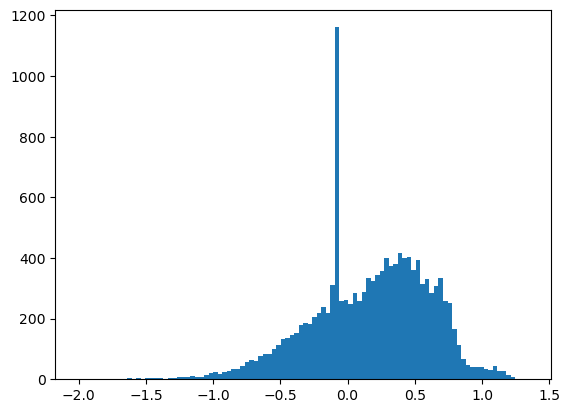

In [39]:
plt.hist(temp_out[:, 0].detach().cpu().numpy(), bins=100)
plt.show()

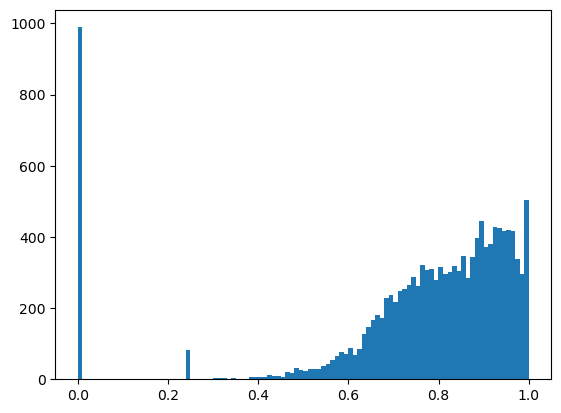

In [42]:
plt.hist(temp[:, 0].detach().cpu().numpy(), bins=100)
plt.show()

In [53]:
temp[np.where(~torch.isfinite(temp_out[:, 0]).cpu())[0], :]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [52]:
bijector.inv(temp[np.where(~torch.isfinite(temp_out[:, 0]).cpu())[0], 0])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Training model on RealNVP-transformed data

Step 1: Load the data

In [10]:
X_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_train.npy"))
y_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy"))
X_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_val.npy"))
y_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_val.npy"))

#preprocess = StandardScalerTimeSeries()
#X_train[:, :, 11:] = preprocess.fit_transform(X_train[:, :, 11:], y_train)
#X_val[:, :, 11:] = preprocess.transform(X_val[:, :, 11:])

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

In [11]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=10)

In [12]:
hist = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs=50, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
np.save(os.path.join(cfg['experiment_directory'], 'normalizing_flow_small_history.npy'), hist)

In [17]:
np.min(hist['val_loss'])

0.2249893479877048

In [18]:
np.min(hist['val_amex_metric'])

0.7698227349840046

In [8]:
standard_scaling = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
standard_scaling['val_loss'][0], standard_scaling['val_amex_metric'][0]

(array([0.22735007, 0.22445291, 0.2232345 , 0.22275956, 0.22212165,
        0.22215124, 0.22211825, 0.22168321, 0.22161712, 0.22160993,
        0.22161777, 0.22164823, 0.22166345, 0.22165659, 0.22168927]),
 array([0.77734793, 0.78128873, 0.78234227, 0.78462958, 0.78609896,
        0.78606435, 0.78632146, 0.78674466, 0.78688495, 0.78658075,
        0.78653513, 0.7865156 , 0.78651322, 0.78641881, 0.78657073]))

## Adaptive preprocessing layer as bijector

In [4]:
import importlib
from src.lib import bijector_util
from src.preprocessing import normalizing_flows
importlib.reload(normalizing_flows)
importlib.reload(bijector_util)

<module 'src.lib.bijector_util' from '/home/mas322/amex-project/src/lib/bijector_util.py'>

In [5]:
input_dim = 177 * 13
DEV = torch.device('cuda', 5)

# normalizing flow setup
base_dist = dist.Normal(torch.zeros(input_dim, device=DEV), torch.ones(input_dim, device=DEV)).to_event(1)
bijector = normalizing_flows.AdaptivePreprocessingLayer(
    input_dim,
    init_sigma=1e-4,
    adaptive_shift=True,
    adaptive_scale=True,
    adaptive_outlier_removal=True,
    adaptive_power_transform=True
)
bijector = bijector.to(DEV)
batch_preprocess_fn = lambda x : x[:, :, 11:].flatten(1, 2)
batch_postprocess_fn = lambda x_in, x_out : np.concatenate((x_in[:, :, :11], x_out.unflatten(1, (13, 177))), axis=2) 

# optimizer
base_lr = 1e-3
optimizer = torch.optim.Adam(
    params=bijector.get_optimizer_param_list(base_lr, 10, 10, 1e-1, 1e-3),
    lr=base_lr,
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 8], gamma=0.1)

bijector_util.fit_bijector(bijector, base_dist, train_loader, val_loader, optimizer=optimizer,
             scheduler=scheduler, batch_preprocess_fn=batch_preprocess_fn,
             num_epochs=4, inverse_fit=False, max_errors_ignore=5)

Fitting bijector:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

In [41]:
for X, _ in train_loader:
    break
x_in = X[:, :, 11:].flatten(1, 2)
out = bijector.inv(x_in.to(DEV)).detach().cpu().numpy()
x_in = x_in.numpy()
out.shape

(1024, 2301)

0.034867276 0.9796325


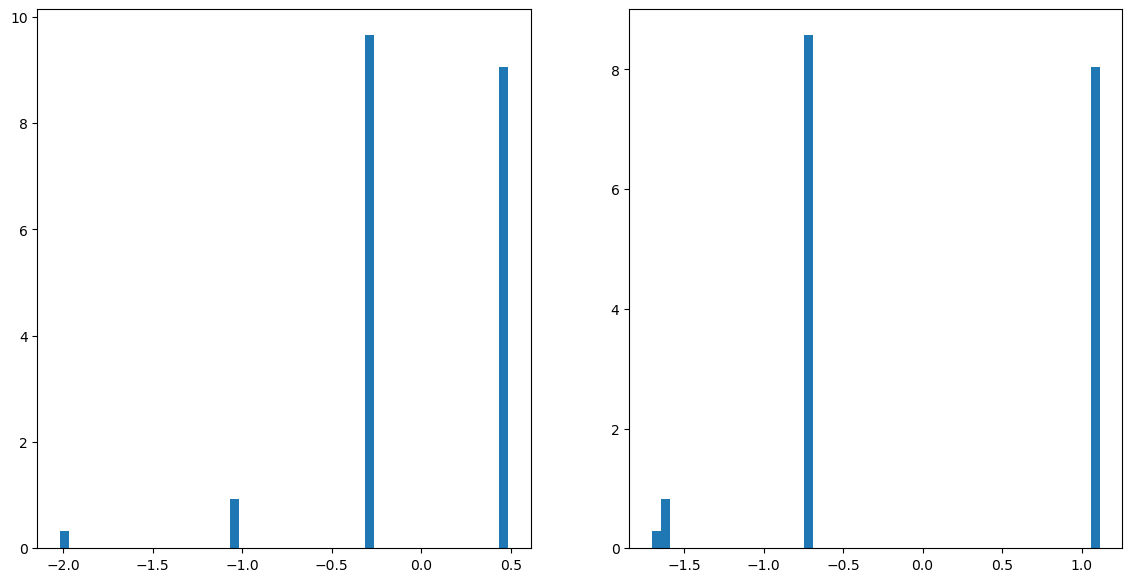

In [42]:
idx = 1900
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(x_in[:, idx], density=True, bins=50)
axs[1].hist(out[:, idx], density=True, bins=50)
print(np.mean(out[:, idx]), np.std(out[:, idx]))
plt.show()

-0.08406007 0.43588686


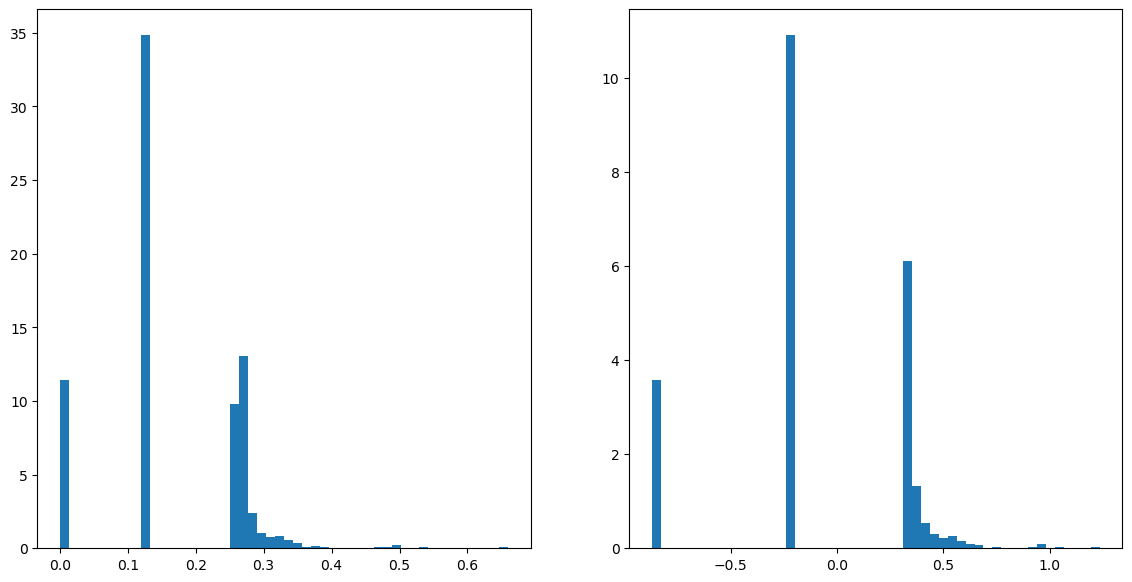

In [31]:
# this is with inverse scale first
idx = 43
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(x_in[:, idx], density=True, bins=50)
axs[1].hist(out[:, idx], density=True, bins=50)
print(np.mean(out[:, idx]), np.std(out[:, idx]))
plt.show()

In [156]:
train_out = bijector_util.transform_data(bijector, train_loader, batch_preprocess_fn, batch_postprocess_fn)
val_out = bijector_util.transform_data(bijector, val_loader, batch_preprocess_fn, batch_postprocess_fn)

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [156]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-X_train.npy"), train_out[0])
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-y_train.npy"), train_out[1])

In [157]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-y_val.npy"), val_out[1])
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-X_val.npy"), val_out[0])

In [157]:
X_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-X_train.npy"))
y_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-y_train.npy"))
X_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-X_val.npy"))
y_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-3-y_val.npy"))

X_train, y_train = train_out
X_val, y_val = val_out

#preprocess = StandardScalerTimeSeries()
#X_train[:, :, 11:] = preprocess.fit_transform(X_train[:, :, 11:], y_train)
#X_val[:, :, 11:] = preprocess.transform(X_val[:, :, 11:])

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

train_loader_amex = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader_amex = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

In [158]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=5)
hist = experimentation.fit_model(model, loss_fn, train_loader_amex, val_loader_amex, optimizer, scheduler, num_epochs=20, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/20 [00:00<?, ?it/s]

### Learning rate tuning of the adaptive preprocessing layer

This is just using scaling and shifting (the results vary a lot, so not very stable):

In [16]:
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7866382524935396, 0.22218426399760777)

In [49]:
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7882901791634209, 0.22149099773830838)

In [11]:
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7862116110919555, 0.2223173264000151)

This is using scale+shift and outlier removal:

In [21]:
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7862533088994235, 0.22171899096833336)

This is using all 4 layers (Note that only the power transform LR varies between these, rest set to `10, 10, 1e-1`.

In [26]:
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7871013451832184, 0.22217635462681454)

In [31]:
# using all four, but very small learning rate on power transform: 1e-30
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7876881246420845, 0.2217669892642233)

In [37]:
# using all four, but small learning rate on power transform: 1e-7
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7883357453234136, 0.22155021412505044)

In [42]:
# using all four, but small learning rate on power transform: 1e-6
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7864701749675057, 0.22173647433519364)

In [50]:
# using all four, but small learning rate on power transform: 1e-3
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.786923385194578, 0.22166601866483687)

In [56]:
# using all four, but small learning rate on power transform: 1e-1
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7882786729878303, 0.22156009508503807)

In [57]:
torch.min(bijector.power_transform.lambd), torch.max(bijector.power_transform.lambd)

(tensor(0.8359, device='cuda:5', grad_fn=<MinBackward1>),
 tensor(1.1448, device='cuda:5', grad_fn=<MaxBackward1>))

In [62]:
# using all four, but small learning rate on power transform: 1
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7857137415375435, 0.22205253160662122)

In [64]:
torch.min(bijector.power_transform.lambd), torch.max(bijector.power_transform.lambd)

(tensor(-0.1484, device='cuda:5', grad_fn=<MinBackward1>),
 tensor(1.9866, device='cuda:5', grad_fn=<MaxBackward1>))

In [65]:
torch.min(bijector.outlier_removal.log_cutoff), torch.max(bijector.outlier_removal.log_cutoff)

(tensor(-0.0962, device='cuda:5', grad_fn=<MinBackward1>),
 tensor(-0.0036, device='cuda:5', grad_fn=<MaxBackward1>))

Still all four, enabled, but now tuning outlier removal lr (with power transform set on `1e-1`:

In [70]:
# using all four, but small learning rate on outlier removal: 10
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7445842491388794, 0.2489742762512631)

In [71]:
torch.min(bijector.outlier_removal.log_cutoff), torch.max(bijector.outlier_removal.log_cutoff)

(tensor(-10.1154, device='cuda:5', grad_fn=<MinBackward1>),
 tensor(-0.9033, device='cuda:5', grad_fn=<MaxBackward1>))

In [76]:
# using all four, but small learning rate on outlier removal: 1
np.max(hist['val_amex_metric']), np.min(hist['val_loss'])

(0.7813487255914964, 0.22591213434934615)

In [77]:
torch.min(bijector.outlier_removal.log_cutoff), torch.max(bijector.outlier_removal.log_cutoff)

(tensor(-2.7431, device='cuda:5', grad_fn=<MinBackward1>),
 tensor(-0.0829, device='cuda:5', grad_fn=<MaxBackward1>))

## Adaptive power transform on skewed synthesized data

In [126]:
from src.lib.synthetic_data import SyntheticData
from scipy import stats
import importlib
from src.lib import bijector_util
from src.experiments.static_preprocessing_methods.standard_scaling import StandardScalerTimeSeries
from src.preprocessing import normalizing_flows
importlib.reload(normalizing_flows)
importlib.reload(bijector_util)

D = 3
T = 13
N = 1024 * 30

# lower bound, upper bound, and unormalized PDF
# Skewed normal distribution: pdf(x) * cdf(alpha * x)
bounds = [(-8, 8), (-8, 8), (-8, 8)]
f1 = lambda x: stats.norm.cdf(10 * x) * stats.norm.pdf(x)
f2 = lambda x: stats.norm.cdf(40 * x) * stats.norm.pdf(x)
f3 = lambda x: stats.norm.cdf(-2 * x) * stats.norm.pdf(x)
# both of the two time-series will be q=3 and q=2, respecitvely
thetas = np.array([
    [-1., 0.5, -0.2, 0.8],
    [-1., 0.3, 0.9, 0.0],
    [-1., 0.9, 0.3, -0.4]
])

synth_data = SyntheticData(
    dim_size = D,
    time_series_length = T,
    pdfs = [f1, f2, f3],
    pdf_bounds = bounds,
    ar_q = 3,
    ar_thetas = thetas,
    cross_variables_cor_init_sigma=1.4,
    response_noise_sigma=0.5,
    response_beta_sigma=2.0,
    random_state=42,
)

X, y = synth_data.generate_data(N, random_state=42)

# 80-20 train-val split
train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[:int(N*0.8)]).type(torch.float32),
        torch.from_numpy(y[:int(N*0.8)]).type(torch.float32)),
    batch_size=1024, shuffle = True)
val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[int(N*0.8):]).type(torch.float32),
        torch.from_numpy(y[int(N*0.8):]).type(torch.float32)),
    batch_size=1024, shuffle = True)

In [127]:
input_dim = D * T
DEV = torch.device('cuda', 5)

# normalizing flow setup
base_dist = dist.Normal(torch.zeros(input_dim, device=DEV), torch.ones(input_dim, device=DEV)).to_event(1)
bijector = normalizing_flows.AdaptivePreprocessingLayer(
    input_dim,
    init_sigma=1e-4,
    adaptive_shift=True,
    adaptive_scale=True,
    adaptive_outlier_removal=False,
    adaptive_power_transform=True
)
bijector = bijector.to(DEV)
batch_preprocess_fn = lambda x : x.flatten(1, 2)
batch_postprocess_fn = lambda _, x_out : x_out.unflatten(1, (T, D))

# optimizer
base_lr = 1e-3
optimizer = torch.optim.Adam(
    params=bijector.get_optimizer_param_list(base_lr, 10, 10, None, 10),
    lr=base_lr,
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 8], gamma=0.1)

bijector_util.fit_bijector(bijector, base_dist, train_loader, optimizer=optimizer,
             scheduler=scheduler, batch_preprocess_fn=batch_preprocess_fn,
             num_epochs=6, inverse_fit=False, max_errors_ignore=5)

Fitting bijector:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [128]:
bijector.power_transform.lambd

Parameter containing:
tensor([0.3958, 0.3587, 1.2438, 0.3882, 0.3459, 1.2352, 0.3895, 0.3526, 1.2420,
        0.3926, 0.3589, 1.2403, 0.3997, 0.3544, 1.2395, 0.3997, 0.3517, 1.2612,
        0.3821, 0.3629, 1.2544, 0.4003, 0.3704, 1.2411, 0.3895, 0.3603, 1.2287,
        0.4073, 0.3606, 1.2405, 0.4020, 0.3596, 1.2366, 0.3924, 0.3566, 1.2492,
        0.3992, 0.3619, 1.2538], device='cuda:5', requires_grad=True)

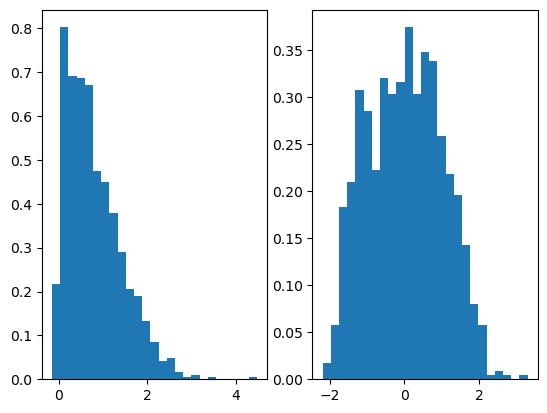

In [129]:
for X_, _ in train_loader:
    break
x_in = X_.flatten(1, 2)
out = bijector.inv(x_in.to(DEV)).detach().cpu().numpy()
x_in = x_in.numpy()
out.shape

fig, ax = plt.subplots(ncols=2)
ax[0].hist(x_in[:, 3], bins=25, density=True)
ax[1].hist(out[:, 3], bins=25, density=True)
plt.show()

In [133]:
X_train, y_train = bijector_util.transform_data(bijector, train_loader, batch_preprocess_fn, batch_postprocess_fn)
X_val, y_val = bijector_util.transform_data(bijector, val_loader, batch_preprocess_fn, batch_postprocess_fn)

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

# the bijector transformed data
train_loader2 = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader2 = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

# the standard scaler data
ss = StandardScalerTimeSeries(T)
X_train = ss.fit_transform(X[:int(N*0.8), :, :])
y_train = y[:int(N*0.8)]
X_val = ss.transform(X[int(N*0.8):, :, :])
y_val = y[int(N*0.8):]

train_loader3 = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader3 = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [138]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(D, 32, 2, 4, num_cat_columns=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=5)
hist = experimentation.fit_model(model, loss_fn, train_loader2, val_loader2, optimizer, scheduler, num_epochs=50, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/50 [00:00<?, ?it/s]

In [139]:
model = GRUNetBasic(D, 32, 2, 4, num_cat_columns=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=5)
hist = experimentation.fit_model(model, loss_fn, train_loader3, val_loader3, optimizer, scheduler, num_epochs=50, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/50 [00:00<?, ?it/s]

In [141]:
len(train_loader)

24